# Plug flow reactor simulation of Thruster

![caption](Graphics/thruster-details.png)


In [1]:
import cantera as ct
import numpy as np

from matplotlib import pyplot as plt
import csv
import pandas as pd

In [2]:
# input file containing the surface reaction mechanism
cti_file = '../RMG-model/cantera/chem_annotated.cti'

# cti_file = '../RMG-model/cantera/chem0050.cti'

gas=ct.Solution(cti_file)
surf = ct.Interface(cti_file,'surface1', [gas])

In [3]:
gas()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         0.81974  kg/m^3
  mean mol. weight         20.1797  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          1905.6        3.845e+04     J
   internal energy      -1.217e+05       -2.456e+06     J
           entropy          7257.7        1.465e+05     J/K
    Gibbs function     -2.1754e+06        -4.39e+07     J
 heat capacity c_p          1030.1        2.079e+04     J/K
 heat capacity c_v          618.03        1.247e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                Ne              1                1         -17.5994
     [  +63 minor]              0                0



In [4]:
print(", ".join(gas.species_names))

Ne, NH3(2), NH2OH(3), HNO3(4), CH3OH(5), H2O(6), N2(7), O2(8), NO2(9), NO(10), N2O(11), CO2(12), H2(13), CO(14), CH4(15), C2H6(16), CH2O(17), CH3(18), C3H8(19), H(20), C2H5(21), HCO(22), CH3CHO(23), OH(24), C2H4(25), O(36), Ar(37), He(38), HO2(39), H2O2(40), HOCO(41), CH2(42), CH2(S)(43), CH(44), CH2OH(45), CH3O(46), HCOH(47), CH3OO(48), CH2CO(49), C2H3(50), C(51), C2H2(52), C2H(53), CH3OOH(54), CH2OOH(55), HOCH2O(56), HOCHO(57), C2H5O(58), C2H5O2(59), C2H5O2(60), cC2H4O(61), CH2CHO(62), H2CC(63), CH3CO(64), C2H4O(65), C2H5O(66), C2H3O2(67), CHCHO(68), OCHCHO(69), NH2(85), H2NO(88), HNOH(93), NO3(95), H2NO3(239)


In [5]:
print(", ".join(surf.species_names))

X(1), HX(26), OX(27), CH3X(28), HOX(29), H2OX(30), CO2X(31), OCX(32), CX(33), CH2X(34), CHX(35), H2NX(201), H3NX(202), H2NOX(203), H2NOX(204), H3NOX(205), NO2X(206), NO3X(207), HNO3X(208), CH3OX(209), CH3OX(210), CH4OX(211)




This example solves a plug flow reactor problem, with coupled surface and gas chemistry.





In [6]:
# unit conversion factors to SI
cm = 0.01 # m
minute = 60.0  # s

In [7]:
#######################################################################
# Input Parameters for combustor
#######################################################################
mass_flow_rate =  0.5e-3 # kg/s
temperature_c = 550.0  # Initial Temperature in Celsius
pressure = ct.one_atm # constant

length = 1.1 * cm  # Catalyst bed length. 11mm
cross_section_area = np.pi * (0.9*cm)**2  # Catalyst bed area.  18mm diameter circle.

### Catalyst properties. Some are hard to estimate
# if we can, update this lit value or verify the value richard calculated
cat_specific_area = 140 # m2/g
cat_density = 2 / cm**3 # 2 g/m3
print(f"Catalyst density {cat_density :.2e} g/m3")
cat_area_per_vol = cat_specific_area * cat_density # m2/m3
cat_area_per_vol *= 1e-3 # REDUCE BY A LOT
print(f"Catalyst area per volume {cat_area_per_vol :.2e} m2/m3")
print()

porosity = 0.38  # Catalyst bed porosity (0.38)
# Al2O3 particles are about 0.7mm diameter

Catalyst density 2.00e+06 g/m3
Catalyst area per volume 2.80e+05 m2/m3



In [8]:
output_filename = 'surf_pfr_output.csv'

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 2001
# dt = 1.0

#####################################################################

temperature_kelvin = temperature_c + 273.15  # convert to Kelvin

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')

# From HAN-molefractions.ipynb
feed_mole_fractions = {
    'NH3(2)': 0.031,
    'NH2OH(3)': 0.32,
    'HNO3(4)': 0.35,
    'CH3OH(5)': 0.21,
    'H2O(6)': 0.09,
}
gas.TPX = temperature_kelvin, pressure, feed_mole_fractions


# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = temperature_kelvin, pressure
surf.coverages = 'X(1):1.0'

r_len = length/(NReactors-1) 
r_vol = cross_section_area * r_len * porosity # gas volume

outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['Distance (mm)', 'T (C)', 'P (atm)'] +
                gas.species_names + surf.species_names + ['gas_heat','surface_heat','alpha'])

# catalyst area in one reactor
cat_area = cat_area_per_vol * r_vol

# Not sure we need the velocity
velocity = mass_flow_rate / (gas.density * cross_section_area)

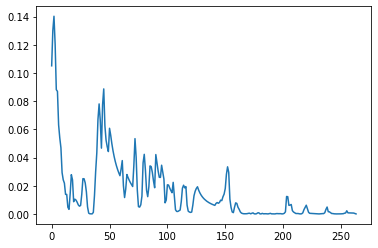


  surface1:

       temperature          823.15  K
          pressure          101325  Pa
           density     5.07815e-06  kg/m^3
  mean mol. weight         196.295  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          -67124       -1.318e+07     J
   internal energy          -67124       -1.318e+07     J
           entropy          27.044             5309     J/K
    Gibbs function          -89385       -1.755e+07     J
 heat capacity c_p          9.4309             1851     J/K
 heat capacity c_v          9.4309             1851     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
              X(1)       0.932732         0.926974       -0.0696885
            HX(26)     0.00010296      0.000102853         -13.2441
            OX(27)      0.0555528        0.0597378         -33.7117
           HOX(29)    6

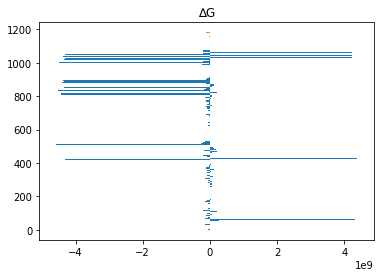

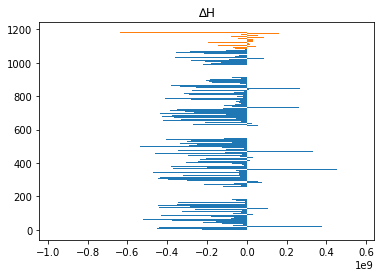

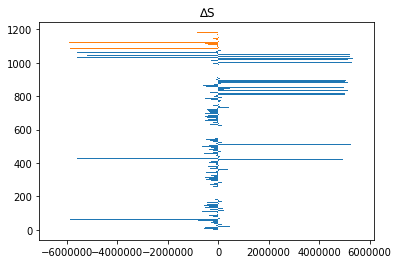

array([ 9.32732356e-01,  1.02960360e-04,  5.55527885e-02,  2.22534688e-19,
        6.81124400e-07,  2.32245848e-04,  3.31813488e-08,  1.13789327e-02,
        1.00889237e-10,  2.00632116e-18,  2.11682764e-11, -2.52850566e-17,
       -6.02839652e-17, -4.28164139e-50, -5.54341186e-27, -1.09328320e-28,
        2.50622885e-09,  1.47387687e-25,  7.83738265e-23,  1.20639208e-24,
        7.01134042e-18,  1.58428734e-21])

In [9]:
# To find the starting coverages, we run the gas to equilibrium,
# (i.e mostly burned products)  then put that in steady state
# with the surface.
TPY = gas.TPY # store to restore
gas.equilibrate('TP')
r = ct.IdealGasReactor(gas, energy='off')
r.volume = r_vol
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
sim = ct.ReactorNet([r])
plt.plot(sim.advance_to_steady_state(return_residuals=True))
plt.show()
surf()
starting_coverages = surf.coverages

print("At equilibrium")
plt.barh(np.arange(len(gas.delta_gibbs)),gas.delta_gibbs)
plt.barh(len(gas.delta_gibbs)+np.arange(len(surf.delta_gibbs)),surf.delta_gibbs)
plt.title("∆G")
plt.show()
plt.barh(np.arange(len(gas.delta_enthalpy)),gas.delta_enthalpy)
plt.barh(len(gas.delta_enthalpy)+np.arange(len(surf.delta_enthalpy)),surf.delta_enthalpy)
plt.title('∆H')
plt.show()
plt.barh(np.arange(len(gas.delta_entropy)),gas.delta_entropy)
plt.barh(len(gas.delta_entropy)+np.arange(len(surf.delta_entropy)),surf.delta_entropy)
plt.title('∆S')
plt.show()

gas.TPY = TPY # restore to starting conditions
del(r, rsurf)
starting_coverages

<BarContainer object of 64 artists>

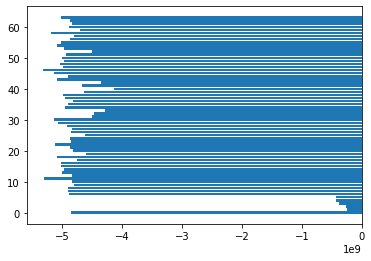

In [10]:
plt.barh(np.arange(len(gas.chemical_potentials)),gas.chemical_potentials)

In [11]:
# gas.equilibrate('TP')

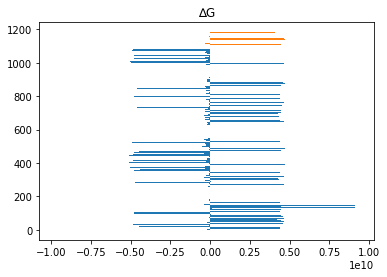

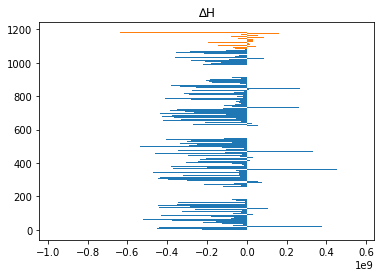

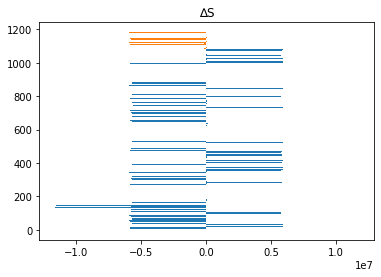

In [12]:
plt.barh(np.arange(len(gas.delta_gibbs)),gas.delta_gibbs)
plt.barh(len(gas.delta_gibbs)+np.arange(len(surf.delta_gibbs)),surf.delta_gibbs)
plt.title("∆G")
plt.show()
plt.barh(np.arange(len(gas.delta_enthalpy)),gas.delta_enthalpy)
plt.barh(len(gas.delta_enthalpy)+np.arange(len(surf.delta_enthalpy)),surf.delta_enthalpy)
plt.title('∆H')
plt.show()
plt.barh(np.arange(len(gas.delta_entropy)),gas.delta_entropy)
plt.barh(len(gas.delta_entropy)+np.arange(len(surf.delta_entropy)),surf.delta_entropy)
plt.title('∆S')
plt.show()

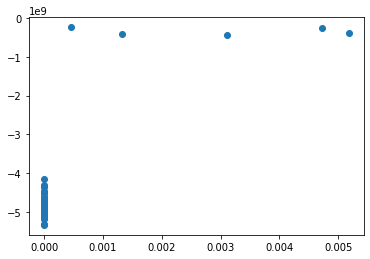

In [13]:
plt.plot(gas.concentrations, gas.chemical_potentials, 'o')

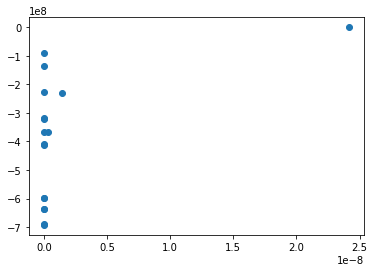

In [14]:
plt.plot(surf.concentrations, surf.chemical_potentials, 'o')

In [15]:
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.reverse_rates_of_progress[i]:8.1g}")

    print(f"\nSurface rates have been scaled by surface/volume ratio {cat_area_per_vol:.1e} m2/m3")
    print("So are on a similar basis of volume of reactor (though porosity not yet accounted for)")
    print(" kmol / m3 / s")
report_rates()


Highest net rates of progress, gas
 47 : NO2(9) + OH(24) (+M) <=> HNO3(4) (+M)                 -0.8
 64 : NH2OH(3) (+M) <=> NH2(85) + OH(24) (+M)              2e-05
 82 : H2NO(88) + H2NO3(239) <=> HNO3(4) + NH2OH(3)        -4e-06
 75 : H(20) + H2NO(88) <=> NH2OH(3)                       -1e-07
 95 : H2NO3(239) + HNOH(93) <=> HNO3(4) + NH2OH(3)        -2e-09
 94 : H(20) + HNOH(93) <=> NH2OH(3)                       -2e-10
 42 : CH3(18) + OH(24) <=> CH3OH(5)                       -7e-12

Highest net rates of progress, surface
  2 : H2O(6) + X(1) <=> H2OX(30)                          -4e+05
  0 : NH2OH(3) + X(1) <=> H3NOX(205)                       2e+04
  1 : HNO3(4) + X(1) <=> HNO3X(208)                        2e+04
  4 : CH3OH(5) + X(1) <=> CH4OX(211)                       1e+04
  3 : NH3(2) + X(1) <=> H3NX(202)                          3e+03
 57 : CO2(12) + X(1) <=> CO2X(31)                         -3e+02
 10 : H2O(6) + 2 X(1) <=> HOX(29) + HX(26)                -2e+01

Highest forwa

In [16]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, gas
891 : 2 CH3CO(64) <=> CH2CO(49) + CH3CHO(23)             5.4e+11
655 : C2H5(21) + HOCO(41) <=> C2H4(25) + HOCHO(57)       5.4e+11
868 : CH3CO(64) + CH3O(46) <=> CH2O(17) + CH3CHO(23)     5.4e+11
660 : CH3O(46) + HOCO(41) <=> CH2O(17) + HOCHO(57)       5.4e+11
872 : C2H5(21) + CH3CO(64) <=> C2H4(25) + CH3CHO(23)     5.4e+11
888 : CH3CO(64) + HCO(22) <=> CH2CO(49) + CH2O(17)       5.4e+11
905 : CH3CO(64) + HOCO(41) <=> CH2CO(49) + HOCHO(57)     5.4e+11

Highest forward rate constants, surface
 76 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 77 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 62 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 45 : HX(26) + OX(27) <=> HOX(29) + X(1)                 2.5e+19
 88 : CHX(35) + HOX(29) <=> CH2X(34) + OX(27)            1.8e+19
 65 : CH2X(34) + HOX(29) <=> CH3X(28) + OX(27)           1.7e+19
 61 : CX(33) + OX(27) <=> OCX(32) + X(1)                 3.7e+18

Highest rev

In [17]:
# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

TDY = gas.TDY
cov = surf.coverages

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='on')
r.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 24

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-11
sim.atol = 1.0e-20

sim.verbose = False

# surf.set_multiplier(0.)  # turn off surface reactions
# surf.set_multiplier(1e6)  # make surface reactions a million times faster


print('    distance(mm)     T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha')
for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = TDY = r.thermo.TDY

    upstream.syncState()
    sim.reinitialize()
    try:
#         the default is residual_threshold = sim.rtol*10
#         sim.advance_to_steady_state(residual_threshold = sim.rtol*1e3)
        sim.advance_to_steady_state()

    except ct.CanteraError:
        t = sim.time
        sim.set_initial_time(0)
        gas.TDY = TDY
        r.syncState()
        sim.reinitialize()
        print(f"Couldn't reach {t:.1g} s so going to {0.1*t:.1g} s")
        sim.advance(0.1*t)
        report_rates()
        report_rate_constants()
 
    dist = n * r_len * 1.0e3   # distance in mm
        
    gas_heat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) # heat evolved by gas phase reaction
    surface_heat = cat_area_per_vol * np.dot(surf.net_rates_of_progress, surf.delta_enthalpy) # heat evolved by surf phase reaction 
    alpha = surface_heat / (surface_heat + gas_heat) # fraction of heat release that is on surface.

    if not n % 10:
        print('    {:10f}  {:7.1f}  {:10f}  {:10f}  {:10f} {:10f}  {:5.1e}'.format(dist, r.T-273.15, *gas['NH3(2)','NH2OH(3)','HNO3(4)','CH3OH(5)'].X, alpha ))

    # write the gas mole fractions and surface coverages vs. distance
    writer.writerow([dist, r.T - 273.15, r.thermo.P/ct.one_atm] +
                    list(gas.X) + list(surf.coverages) + [gas_heat, surface_heat, alpha])
    
    #report_rates()
    #report_rate_constants()

outfile.close()
print("Results saved to '{0}'".format(output_filename))

    distance(mm)     T (C)    NH3(2)   NH2OH(3)     HNO3(4)    CH3OH(5)  alpha
      0.000000    552.7    0.032980    0.314299    0.348956   0.209142  1.0e+00
      0.055000    586.7    0.055832    0.254990    0.340950   0.201514  1.0e+00
      0.110000    638.3    0.083827    0.187751    0.330008   0.190864  1.0e+00
      0.165000    719.9    0.115407    0.121856    0.310055   0.173752  1.0e+00
      0.220000    869.0    0.139041    0.072570    0.231955   0.133402  1.3e+00
      0.275000   1185.6    0.116589    0.033045    0.004924   0.057377  1.2e+00
      0.330000   1227.5    0.117485    0.022629    0.000061   0.040675  1.2e+00
      0.385000   1252.7    0.119303    0.015007    0.000047   0.029366  1.2e+00
      0.440000   1278.0    0.120722    0.009392    0.000038   0.021141  1.2e+00
      0.495000   1302.5    0.121671    0.005478    0.000030   0.015152  1.1e+00
      0.550000   1325.7    0.122218    0.002994    0.000024   0.010803  9.7e-01
      0.605000   1347.7    0.122443    0.

      1.485000   1953.9    0.080364    0.000018    0.000000   0.000000  -5.8e-01
Couldn't reach 0.002 s so going to 0.0002 s

Highest net rates of progress, gas
 74 : H(20) + H2NO(88) <=> NH2(85) + OH(24)                3e+01
 62 : NH2(85) + NO(10) <=> H2O(6) + N2(7)                  3e+01
 61 : NH3(2) + OH(24) <=> H2O(6) + NH2(85)                 2e+01
233 : NH2(85) + O(36) <=> H2NO(88)                            -8
 46 : H(20) + NO2(9) <=> NO(10) + OH(24)                       6
 70 : NH2(85) + NO2(9) <=> H2NO(88) + NO(10)                   5
 33 : H2(13) + OH(24) <=> H(20) + H2O(6)                       5

Highest net rates of progress, surface
 45 : HX(26) + OX(27) <=> HOX(29) + X(1)                  -3e+01
  6 : H(20) + X(1) <=> HX(26)                             -3e+01
 11 : OH(24) + X(1) <=> HOX(29)                            2e+01
 43 : O2(8) + 2 X(1) <=> 2 OX(27)                         -1e+01
 57 : CO2(12) + X(1) <=> CO2X(31)                             -9
 58 : CO(14) + X(1)

      1.540000   2005.7    0.074146    0.000014    0.000000   0.000000  -8.7e-01
      1.595000   2049.9    0.069243    0.000012    0.000000   0.000000  -1.1e+00
Couldn't reach 0.0008 s so going to 8e-05 s

Highest net rates of progress, gas
 62 : NH2(85) + NO(10) <=> H2O(6) + N2(7)                  3e+01
 74 : H(20) + H2NO(88) <=> NH2(85) + OH(24)                2e+01
 61 : NH3(2) + OH(24) <=> H2O(6) + NH2(85)                 1e+01
233 : NH2(85) + O(36) <=> H2NO(88)                            -6
195 : 2 OH(24) <=> H2O(6) + O(36)                             -4
228 : N2O(11) (+M) <=> N2(7) + O(36) (+M)                      3
 33 : H2(13) + OH(24) <=> H(20) + H2O(6)                       3

Highest net rates of progress, surface
 45 : HX(26) + OX(27) <=> HOX(29) + X(1)                  -3e+01
  6 : H(20) + X(1) <=> HX(26)                             -2e+01
 43 : O2(8) + 2 X(1) <=> 2 OX(27)                         -1e+01
 11 : OH(24) + X(1) <=> HOX(29)                            1e+01
  5

      1.650000   2088.1    0.064895    0.000010    0.000000   0.000000  -1.2e+00
      1.705000   2121.1    0.060664    0.000009    0.000000   0.000000  -1.4e+00
Couldn't reach 0.0008 s so going to 8e-05 s

Highest net rates of progress, gas
 62 : NH2(85) + NO(10) <=> H2O(6) + N2(7)                  3e+01
 74 : H(20) + H2NO(88) <=> NH2(85) + OH(24)                1e+01
 61 : NH3(2) + OH(24) <=> H2O(6) + NH2(85)                 1e+01
228 : N2O(11) (+M) <=> N2(7) + O(36) (+M)                      3
233 : NH2(85) + O(36) <=> H2NO(88)                            -3
195 : 2 OH(24) <=> H2O(6) + O(36)                             -2
 48 : H(20) + N2O(11) <=> N2(7) + OH(24)                       2

Highest net rates of progress, surface
 45 : HX(26) + OX(27) <=> HOX(29) + X(1)                  -2e+01
  6 : H(20) + X(1) <=> HX(26)                             -1e+01
 43 : O2(8) + 2 X(1) <=> 2 OX(27)                         -1e+01
  2 : H2O(6) + X(1) <=> H2OX(30)                               8
  5

Couldn't reach 5e-05 s so going to 5e-06 s

Highest net rates of progress, gas
 62 : NH2(85) + NO(10) <=> H2O(6) + N2(7)                  3e+01
 74 : H(20) + H2NO(88) <=> NH2(85) + OH(24)                1e+01
 61 : NH3(2) + OH(24) <=> H2O(6) + NH2(85)                 1e+01
228 : N2O(11) (+M) <=> N2(7) + O(36) (+M)                      3
233 : NH2(85) + O(36) <=> H2NO(88)                            -3
195 : 2 OH(24) <=> H2O(6) + O(36)                             -2
 48 : H(20) + N2O(11) <=> N2(7) + OH(24)                       2

Highest net rates of progress, surface
 45 : HX(26) + OX(27) <=> HOX(29) + X(1)                  -2e+01
  6 : H(20) + X(1) <=> HX(26)                             -1e+01
 43 : O2(8) + 2 X(1) <=> 2 OX(27)                             -9
  2 : H2O(6) + X(1) <=> H2OX(30)                               8
 46 : H2OX(30) + OX(27) <=> 2 HOX(29)                          8
  5 : H2(13) + 2 X(1) <=> 2 HX(26)                            -8
 58 : CO(14) + X(1) <=> OCX(32)     

Couldn't reach 0.0004 s so going to 4e-05 s

Highest net rates of progress, gas
 62 : NH2(85) + NO(10) <=> H2O(6) + N2(7)                  2e+01
 61 : NH3(2) + OH(24) <=> H2O(6) + NH2(85)                     7
 74 : H(20) + H2NO(88) <=> NH2(85) + OH(24)                    3
228 : N2O(11) (+M) <=> N2(7) + O(36) (+M)                      2
233 : NH2(85) + O(36) <=> H2NO(88)                            -1
 48 : H(20) + N2O(11) <=> N2(7) + OH(24)                       1
 60 : H(20) + NH3(2) <=> H2(13) + NH2(85)                      1

Highest net rates of progress, surface
 45 : HX(26) + OX(27) <=> HOX(29) + X(1)                  -1e+01
  6 : H(20) + X(1) <=> HX(26)                                 -8
  2 : H2O(6) + X(1) <=> H2OX(30)                               6
 46 : H2OX(30) + OX(27) <=> 2 HOX(29)                          6
 11 : OH(24) + X(1) <=> HOX(29)                               -6
 58 : CO(14) + X(1) <=> OCX(32)                               -5
 57 : CO2(12) + X(1) <=> CO2X(31)  

      1.980000   2229.8    0.042831    0.000006    0.000000   0.000000  -1.9e+00
Couldn't reach 0.0004 s so going to 4e-05 s

Highest net rates of progress, gas
 62 : NH2(85) + NO(10) <=> H2O(6) + N2(7)                  2e+01
 61 : NH3(2) + OH(24) <=> H2O(6) + NH2(85)                     6
 74 : H(20) + H2NO(88) <=> NH2(85) + OH(24)                    2
233 : NH2(85) + O(36) <=> H2NO(88)                            -1
228 : N2O(11) (+M) <=> N2(7) + O(36) (+M)                      1
 60 : H(20) + NH3(2) <=> H2(13) + NH2(85)                    0.9
 48 : H(20) + N2O(11) <=> N2(7) + OH(24)                     0.9

Highest net rates of progress, surface
 45 : HX(26) + OX(27) <=> HOX(29) + X(1)                      -8
  6 : H(20) + X(1) <=> HX(26)                                 -7
 11 : OH(24) + X(1) <=> HOX(29)                               -6
  2 : H2O(6) + X(1) <=> H2OX(30)                               5
 46 : H2OX(30) + OX(27) <=> 2 HOX(29)                          5
 58 : CO(14) + X(1)

CanteraError: 
***********************************************************************
CanteraError thrown by CVodesIntegrator::integrate:
CVodes error encountered. Error code: -10
At t = 1.32265e-14 repeated recoverable right-hand side function errors.

Exceptions caught during RHS evaluation:

***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -nan
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -nan
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -nan
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[78] = -inf
ydot[79] = -nan
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -nan
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -nan
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -nan
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[78] = -inf
ydot[79] = -nan
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -nan
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -nan
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -nan
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[78] = -inf
ydot[79] = -nan
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -nan
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -nan
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -nan
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[78] = -inf
ydot[79] = -nan
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -nan
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -nan
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -nan
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[78] = -inf
ydot[79] = -nan
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -nan
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -nan
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -nan
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[78] = -inf
ydot[79] = -nan
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -nan
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -nan
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -nan
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[78] = -inf
ydot[79] = -nan
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -nan
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -nan
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -nan
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[78] = -inf
ydot[79] = -nan
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -nan
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -nan
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -nan
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[78] = -inf
ydot[79] = -nan
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************


***********************************************************************
CanteraError thrown by checkFinite:
ydot contains non-finite elements:

ydot[0] = inf
ydot[2] = -nan
ydot[3] = -inf
ydot[4] = -nan
ydot[5] = -nan
ydot[6] = -nan
ydot[7] = -nan
ydot[8] = -nan
ydot[9] = -inf
ydot[10] = -nan
ydot[11] = -nan
ydot[12] = -nan
ydot[13] = -nan
ydot[14] = -nan
ydot[15] = -nan
ydot[16] = -nan
ydot[17] = -nan
ydot[18] = -nan
ydot[19] = -nan
ydot[20] = -nan
ydot[21] = -inf
ydot[22] = -nan
ydot[23] = -nan
ydot[24] = -nan
ydot[25] = -nan
ydot[26] = -nan
ydot[27] = -nan
ydot[28] = -nan
ydot[29] = -nan
ydot[30] = -nan
ydot[31] = -nan
ydot[32] = -nan
ydot[33] = -nan
ydot[34] = -nan
ydot[35] = -nan
ydot[36] = -nan
ydot[37] = -nan
ydot[38] = -nan
ydot[39] = -inf
ydot[40] = -nan
ydot[41] = -nan
ydot[42] = -nan
ydot[43] = -nan
ydot[44] = -nan
ydot[45] = -nan
ydot[46] = -nan
ydot[47] = -nan
ydot[48] = -nan
ydot[49] = -inf
ydot[50] = -nan
ydot[51] = -nan
ydot[52] = -inf
ydot[53] = -nan
ydot[54] = -nan
ydot[55] = -nan
ydot[56] = -nan
ydot[57] = -nan
ydot[58] = -nan
ydot[59] = -nan
ydot[60] = -nan
ydot[61] = -nan
ydot[62] = -nan
ydot[63] = -nan
ydot[64] = -nan
ydot[65] = -nan
ydot[66] = -inf
ydot[67] = -nan
ydot[68] = -nan
ydot[69] = -nan
ydot[70] = -inf
ydot[71] = -nan
ydot[72] = -nan
ydot[73] = inf
ydot[74] = -inf
ydot[75] = inf
ydot[76] = -nan
ydot[77] = -nan
ydot[78] = -inf
ydot[79] = -nan
ydot[80] = -inf
ydot[81] = -nan
ydot[82] = -nan
ydot[83] = -inf
ydot[84] = -inf
ydot[85] = inf
ydot[86] = -inf
ydot[87] = -nan
ydot[88] = -nan
***********************************************************************

Components with largest weighted error estimates:
0: inf
1: 0
2: -nan
3: -inf
4: -nan
5: -nan
6: -nan
7: -nan
8: -nan
9: -inf
***********************************************************************


In [18]:
sim.time

0.0

In [19]:
gas.TDY = TDY
r.syncState()
r.thermo.T

2515.9664357012257

In [20]:
r.thermo.X - gas.X

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
rsurf.kinetics.net_rates_of_progress

array([          -inf, 4.33895326e-10,           -inf,           -inf,
                 -inf, 1.22086307e-01, 7.53109396e-02,           -inf,
       1.05167969e-11,           -inf,           -inf,           -inf,
                 -inf,           -inf, 1.05540073e-11, 1.40887139e-07,
                 -inf,           -inf,           -inf, 3.91308745e-11,
       1.50620119e-04,           -inf, 3.91308745e-11,           -inf,
                 -inf, 9.23305219e-19,           -inf,           -inf,
                 -inf,           -inf,           -inf,           -inf,
       6.13145541e-19,           -inf, 1.53436485e-19,           -inf,
                 -inf,           -inf,           -inf,           -inf,
                 -inf,           -inf,           -inf,           -inf,
                 -inf,           -inf, 2.65625178e-02, 8.22196396e-21,
       2.92838348e-13, 1.00809982e-19,           -inf, 7.65565751e-11,
                 -inf, 1.02379200e-06, 1.02008554e-06,           -inf,
      

In [22]:
surf.net_rates_of_progress

array([          -inf, 4.33895326e-10,           -inf,           -inf,
                 -inf, 1.22086307e-01, 7.53109396e-02,           -inf,
       1.05167969e-11,           -inf,           -inf,           -inf,
                 -inf,           -inf, 1.05540073e-11, 1.40887139e-07,
                 -inf,           -inf,           -inf, 3.91308745e-11,
       1.50620119e-04,           -inf, 3.91308745e-11,           -inf,
                 -inf, 9.23305219e-19,           -inf,           -inf,
                 -inf,           -inf,           -inf,           -inf,
       6.13145541e-19,           -inf, 1.53436485e-19,           -inf,
                 -inf,           -inf,           -inf,           -inf,
                 -inf,           -inf,           -inf,           -inf,
                 -inf,           -inf, 2.65625178e-02, 8.22196396e-21,
       2.92838348e-13, 1.00809982e-19,           -inf, 7.65565751e-11,
                 -inf, 1.02379200e-06, 1.02008554e-06,           -inf,
      

In [23]:
gas.TDY

(2515.9664357012257,
 0.1111038701633827,
 array([6.17543864e-085, 3.01052763e-002, 8.73266900e-006, 4.96029306e-010,
        2.93028135e-013, 4.05591934e-001, 1.15887144e-001, 3.54139160e-002,
        1.07417874e-004, 1.27366217e-001, 2.38606061e-003, 1.81179869e-001,
        1.91832678e-003, 2.64186823e-002, 4.40462321e-012, 6.07110966e-020,
        3.54823227e-010, 1.75863053e-011, 6.89231261e-030, 1.74176058e-004,
        1.53685849e-018, 7.72130548e-009, 2.59929809e-015, 1.67933574e-002,
        4.12529888e-014, 1.66142926e-003, 2.47069885e-116, 0.00000000e+000,
        1.12551877e-005, 8.14158425e-007, 4.48918017e-008, 1.88793803e-011,
        1.02083439e-012, 1.06923322e-012, 3.11801197e-012, 6.55240685e-014,
        3.69289693e-014, 2.04798839e-017, 3.93837917e-010, 9.59268715e-014,
        1.07121769e-012, 2.37080781e-009, 3.82499925e-011, 6.01586401e-019,
        2.60296351e-017, 2.27103385e-016, 9.99308400e-009, 1.19631130e-022,
        1.97272686e-026, 1.69102903e-025, 2.47

In [24]:
r.thermo.TDY

(2515.9664357012257,
 0.1111038701633827,
 array([6.17543864e-085, 3.01052763e-002, 8.73266900e-006, 4.96029306e-010,
        2.93028135e-013, 4.05591934e-001, 1.15887144e-001, 3.54139160e-002,
        1.07417874e-004, 1.27366217e-001, 2.38606061e-003, 1.81179869e-001,
        1.91832678e-003, 2.64186823e-002, 4.40462321e-012, 6.07110966e-020,
        3.54823227e-010, 1.75863053e-011, 6.89231261e-030, 1.74176058e-004,
        1.53685849e-018, 7.72130548e-009, 2.59929809e-015, 1.67933574e-002,
        4.12529888e-014, 1.66142926e-003, 2.47069885e-116, 0.00000000e+000,
        1.12551877e-005, 8.14158425e-007, 4.48918017e-008, 1.88793803e-011,
        1.02083439e-012, 1.06923322e-012, 3.11801197e-012, 6.55240685e-014,
        3.69289693e-014, 2.04798839e-017, 3.93837917e-010, 9.59268715e-014,
        1.07121769e-012, 2.37080781e-009, 3.82499925e-011, 6.01586401e-019,
        2.60296351e-017, 2.27103385e-016, 9.99308400e-009, 1.19631130e-022,
        1.97272686e-026, 1.69102903e-025, 2.47

In [25]:
report_rate_constants()


Highest forward rate constants, gas
635 : HOCH2O(56) <=> H(20) + HOCHO(57)                   5.1e+12
692 : C2H5O(58) (+M) <=> CH2O(17) + CH3(18) (+M)         3.0e+12
1026 : CHCHO(68) <=> CH2CO(49)                            2.9e+12
905 : CH3CO(64) + HOCO(41) <=> CH2CO(49) + HOCHO(57)     5.4e+11
868 : CH3CO(64) + CH3O(46) <=> CH2O(17) + CH3CHO(23)     5.4e+11
888 : CH3CO(64) + HCO(22) <=> CH2CO(49) + CH2O(17)       5.4e+11
660 : CH3O(46) + HOCO(41) <=> CH2O(17) + HOCHO(57)       5.4e+11

Highest forward rate constants, surface
 88 : CHX(35) + HOX(29) <=> CH2X(34) + OX(27)            1.8e+22
 64 : CH3OX(210) + X(1) <=> CH2X(34) + HOX(29)           7.1e+21
 62 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 76 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 77 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 65 : CH2X(34) + HOX(29) <=> CH3X(28) + OX(27)           5.8e+20
 59 : OCX(32) + OX(27) <=> CO2X(31) + X(1)               3.7e+20

Highest re

In [26]:
sim.verbose

False

In [27]:
sim.component_name(46)

'IdealGasReactor_2: CH3OOH(54)'

<BarContainer object of 1082 artists>

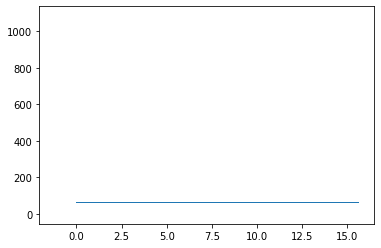

In [28]:
plt.barh(np.arange(len(gas.net_rates_of_progress)),gas.net_rates_of_progress)

In [29]:
gas.T

2515.9664357012257

In [30]:
data = pd.read_csv(output_filename)
data

,Distance (mm),T (C),P (atm),Ne,NH3(2),NH2OH(3),HNO3(4),CH3OH(5),H2O(6),N2(7),...,H3NOX(205),NO2X(206),NO3X(207),HNO3X(208),CH3OX(209),CH3OX(210),CH4OX(211),gas_heat,surface_heat,alpha
0,0.0000,552.693599,1.0,0.000000e+00,0.032980,0.314299,3.489561e-01,2.091421e-01,0.091616,1.973493e-15,...,2.876129e-05,2.382894e-03,3.301056e-06,2.805948e-05,2.413038e-11,1.333556e-04,1.019196e-06,5.281651e+07,-4.721715e+09,1.011312
1,0.0055,555.508345,1.0,0.000000e+00,0.035040,0.308817,3.482450e-01,2.084760e-01,0.093360,1.437119e-14,...,2.943316e-05,3.804839e-03,5.585343e-06,2.873071e-05,2.365740e-11,1.241237e-04,1.062123e-06,3.845077e+07,-4.920906e+09,1.007875
2,0.0110,558.444408,1.0,0.000000e+00,0.037148,0.303234,3.475163e-01,2.077910e-01,0.095141,5.144720e-14,...,3.011723e-05,5.217086e-03,7.381961e-06,2.942652e-05,2.317120e-11,1.152049e-04,1.107865e-06,2.880405e+07,-5.125573e+09,1.005651
3,0.0165,561.502988,1.0,0.000000e+00,0.039305,0.297550,3.467693e-01,2.070862e-01,0.096960,1.355249e-13,...,3.081095e-05,6.617727e-03,8.731220e-06,3.014731e-05,2.267579e-11,1.066393e-04,1.156594e-06,2.323994e+07,-5.336880e+09,1.004374
4,0.0220,564.686277,1.0,0.000000e+00,0.041513,0.291765,3.460031e-01,2.063605e-01,0.098818,3.021467e-13,...,3.151179e-05,8.005140e-03,9.739890e-06,3.089363e-05,2.217445e-11,9.845498e-05,1.208506e-06,2.126454e+07,-5.556078e+09,1.003842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,2.0020,2235.773555,1.0,7.030649e-85,0.041784,0.000006,1.847536e-10,2.791747e-13,0.515754,9.284210e-02,...,6.239981e-11,4.005005e-10,6.674869e-14,1.072648e-15,7.362437e-20,8.995105e-18,4.719250e-18,-8.625458e+09,5.635803e+09,-1.885101
365,2.0075,2237.215730,1.0,7.028366e-85,0.041530,0.000006,1.838922e-10,2.639009e-13,0.515890,9.326152e-02,...,6.204439e-11,3.967278e-10,6.637942e-14,1.066269e-15,7.170178e-20,8.885741e-18,4.459665e-18,-8.543269e+09,5.589137e+09,-1.891973
366,2.0130,2238.640799,1.0,7.026108e-85,0.041280,0.000006,1.830428e-10,2.493495e-13,0.516025,9.367593e-02,...,6.169390e-11,3.930321e-10,6.601650e-14,1.059991e-15,6.988227e-20,8.784553e-18,4.212460e-18,-8.462190e+09,5.542954e+09,-1.898769
367,2.0185,2240.049062,1.0,7.023874e-85,0.041033,0.000006,1.822049e-10,2.354941e-13,0.516157,9.408540e-02,...,6.134819e-11,3.894110e-10,6.565974e-14,1.053812e-15,6.816249e-20,8.691205e-18,3.977173e-18,-8.382206e+09,5.497253e+09,-1.905491


In [31]:
def xlabels():
    plt.xticks([0,NReactors/4,NReactors/2,3*NReactors/4, NReactors],['0','','','',f'{length*1000:.0f} mm'])
    plt.xlabel("Distance down reactor")

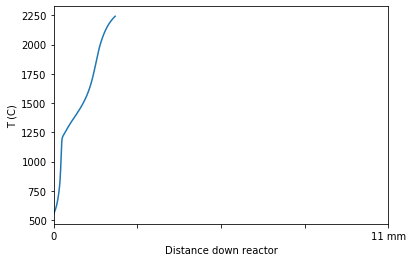

In [32]:
data['T (C)'].plot()
plt.ylabel('T (C)')
xlabels()

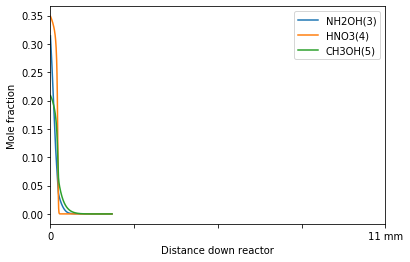

In [33]:
data[['NH2OH(3)', 'HNO3(4)', 'CH3OH(5)']].plot()
plt.ylabel('Mole fraction')
xlabels()

In [34]:
list(data.columns)[:4]

['Distance (mm)', 'T (C)', 'P (atm)', 'Ne']

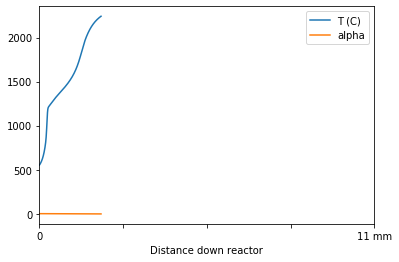

In [35]:
data[['T (C)', 'alpha']].plot()
xlabels()

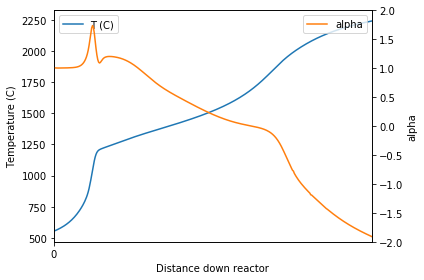

In [36]:
ax1 = data['T (C)'].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.legend()
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, color='tab:orange')
ax2.set_ylim(-2, 2)
plt.legend()
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('temperature-and-alpha.pdf')
plt.show()

In [37]:
data.columns

Index(['Distance (mm)', 'T (C)', 'P (atm)', 'Ne', 'NH3(2)', 'NH2OH(3)',
       'HNO3(4)', 'CH3OH(5)', 'H2O(6)', 'N2(7)', 'O2(8)', 'NO2(9)', 'NO(10)',
       'N2O(11)', 'CO2(12)', 'H2(13)', 'CO(14)', 'CH4(15)', 'C2H6(16)',
       'CH2O(17)', 'CH3(18)', 'C3H8(19)', 'H(20)', 'C2H5(21)', 'HCO(22)',
       'CH3CHO(23)', 'OH(24)', 'C2H4(25)', 'O(36)', 'Ar(37)', 'He(38)',
       'HO2(39)', 'H2O2(40)', 'HOCO(41)', 'CH2(42)', 'CH2(S)(43)', 'CH(44)',
       'CH2OH(45)', 'CH3O(46)', 'HCOH(47)', 'CH3OO(48)', 'CH2CO(49)',
       'C2H3(50)', 'C(51)', 'C2H2(52)', 'C2H(53)', 'CH3OOH(54)', 'CH2OOH(55)',
       'HOCH2O(56)', 'HOCHO(57)', 'C2H5O(58)', 'C2H5O2(59)', 'C2H5O2(60)',
       'cC2H4O(61)', 'CH2CHO(62)', 'H2CC(63)', 'CH3CO(64)', 'C2H4O(65)',
       'C2H5O(66)', 'C2H3O2(67)', 'CHCHO(68)', 'OCHCHO(69)', 'NH2(85)',
       'H2NO(88)', 'HNOH(93)', 'NO3(95)', 'H2NO3(239)', 'X(1)', 'HX(26)',
       'OX(27)', 'CH3X(28)', 'HOX(29)', 'H2OX(30)', 'CO2X(31)', 'OCX(32)',
       'CX(33)', 'CH2X(34)', 'CHX(35)

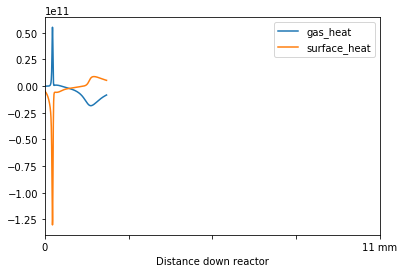

In [38]:
data[['gas_heat','surface_heat']].plot()
#plt.ylim(-1e7, 1e7)
xlabels()
plt.savefig('gas_and_surface_heat.pdf')
plt.show()


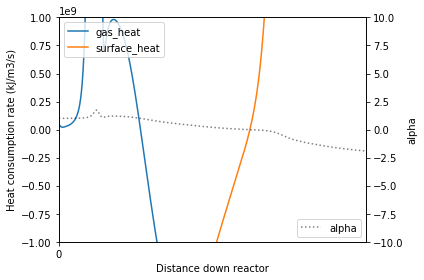

In [39]:
ax1 = data[['gas_heat','surface_heat']].plot()
plt.ylim(-1e9, 1e9)
xlabels()
plt.ylabel('Heat consumption rate (kJ/m3/s)')
plt.legend(loc='upper left')
ax2 = ax1.twinx()
data['alpha'].plot(ax=ax2, style='k:', alpha=0.5)
ax2.set_ylim(-10, 10)
plt.legend(loc='lower right')
plt.ylabel('alpha')
plt.tight_layout()
plt.savefig('heats-and-alpha.pdf')
plt.show()

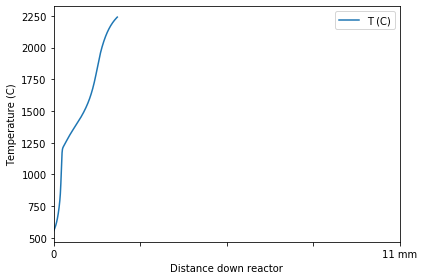

In [40]:
data[['T (C)']].plot()
plt.ylabel('Temperature (C)')
xlabels()
plt.tight_layout()
plt.savefig('temperature.pdf')
plt.show()

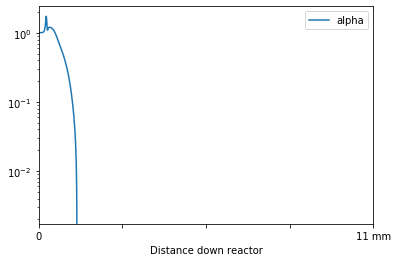

In [41]:
data[['alpha']].plot(logy=True)
xlabels()

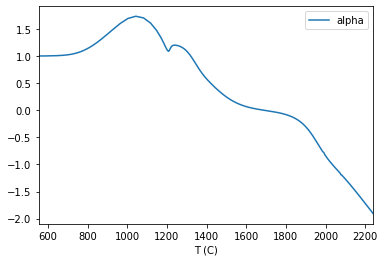

In [42]:
data.plot(x='T (C)',y='alpha')


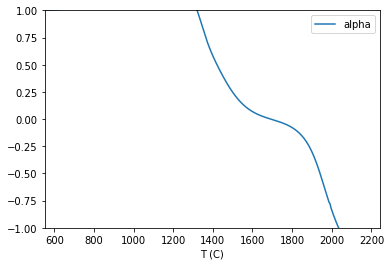

In [43]:
data.plot(x='T (C)',y='alpha', ylim=(-1,1))

In [45]:
specs = list(data.columns)
specs = specs[4:-1]

gas_species = [s for s in specs if 'X' not in s]
adsorbates = [s for s in specs if 'X' in s]

gas_species, adsorbates

(['NH3(2)',
  'NH2OH(3)',
  'HNO3(4)',
  'CH3OH(5)',
  'H2O(6)',
  'N2(7)',
  'O2(8)',
  'NO2(9)',
  'NO(10)',
  'N2O(11)',
  'CO2(12)',
  'H2(13)',
  'CO(14)',
  'CH4(15)',
  'C2H6(16)',
  'CH2O(17)',
  'CH3(18)',
  'C3H8(19)',
  'H(20)',
  'C2H5(21)',
  'HCO(22)',
  'CH3CHO(23)',
  'OH(24)',
  'C2H4(25)',
  'O(36)',
  'Ar(37)',
  'He(38)',
  'HO2(39)',
  'H2O2(40)',
  'HOCO(41)',
  'CH2(42)',
  'CH2(S)(43)',
  'CH(44)',
  'CH2OH(45)',
  'CH3O(46)',
  'HCOH(47)',
  'CH3OO(48)',
  'CH2CO(49)',
  'C2H3(50)',
  'C(51)',
  'C2H2(52)',
  'C2H(53)',
  'CH3OOH(54)',
  'CH2OOH(55)',
  'HOCH2O(56)',
  'HOCHO(57)',
  'C2H5O(58)',
  'C2H5O2(59)',
  'C2H5O2(60)',
  'cC2H4O(61)',
  'CH2CHO(62)',
  'H2CC(63)',
  'CH3CO(64)',
  'C2H4O(65)',
  'C2H5O(66)',
  'C2H3O2(67)',
  'CHCHO(68)',
  'OCHCHO(69)',
  'NH2(85)',
  'H2NO(88)',
  'HNOH(93)',
  'NO3(95)',
  'H2NO3(239)',
  'gas_heat',
  'surface_heat'],
 ['X(1)',
  'HX(26)',
  'OX(27)',
  'CH3X(28)',
  'HOX(29)',
  'H2OX(30)',
  'CO2X(31)',
  'OCX(32

/Users/rwest/opt/anaconda3/envs/rmg3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


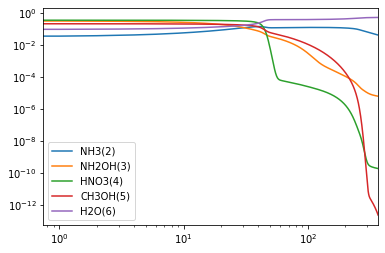

In [46]:
data[gas_species[0:5]].plot(logy=True, logx=True)

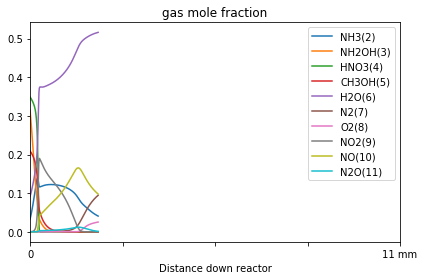

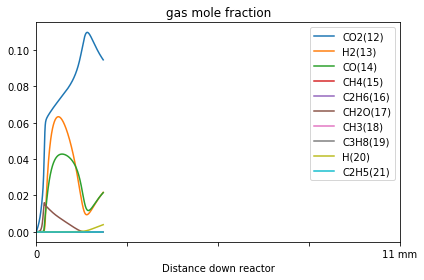

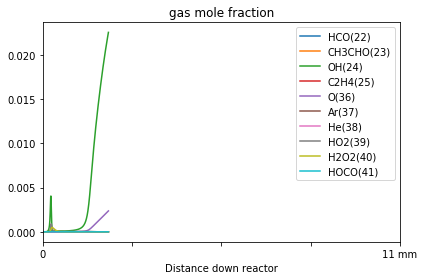

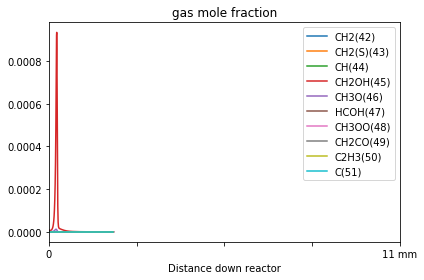

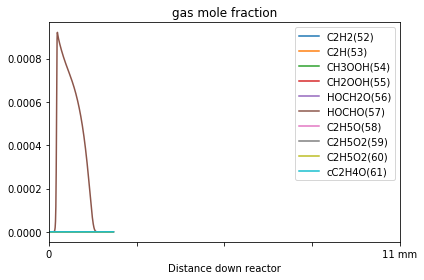

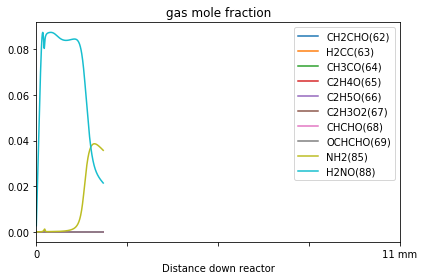

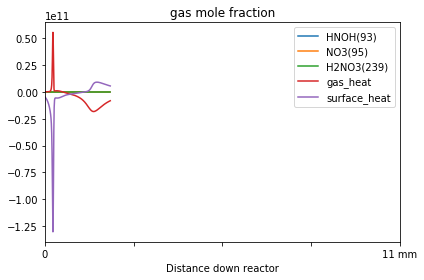

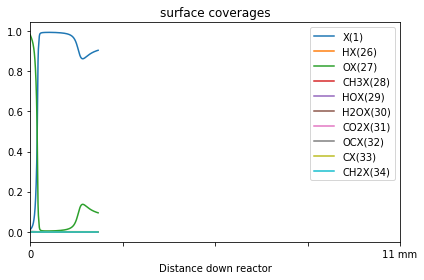

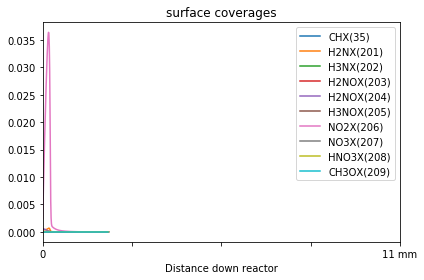

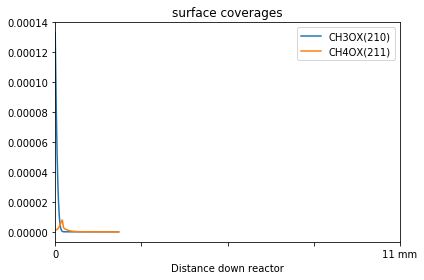

In [47]:
for i in range(0,len(gas_species),10):
    data[gas_species[i:i+10]].plot(title='gas mole fraction', logy=False)
    xlabels()
    plt.tight_layout()
    plt.savefig(f'gas_mole_fractions_{i}.pdf')
    plt.show()
    
for i in range(0,len(adsorbates),10):
    data[adsorbates[i:i+10]].plot(title='surface coverages', logy=False)
    xlabels()
    plt.tight_layout()
    plt.savefig(f'surface_coverages_{i}.pdf')
    plt.show()

In [ ]:
gas.species('NO2(9)').composition

In [ ]:
data['NO2(9)'].plot()

In [ ]:
(data[specs].max()>0.01)

In [ ]:
data.loc[0]